# Model Selection using Crossvalidation

This script will walk you through the process of fitting a linear model using polynomial basis functions, and the selection of a hyper-parameter using a validation data set.

## The Dataset

The following section of the code generates the training and testing sets using the simple model
$$ y = f(x) + \epsilon = 5x(x-0.5)(x-1) + \epsilon$$
where $\epsilon \sim N(0,0.01)$ is a Gaussian noise term with zero mean and standard deviation equal to 0.1.

The training and test data have already been generated for you and the section below shows you how to load them and what they look like.

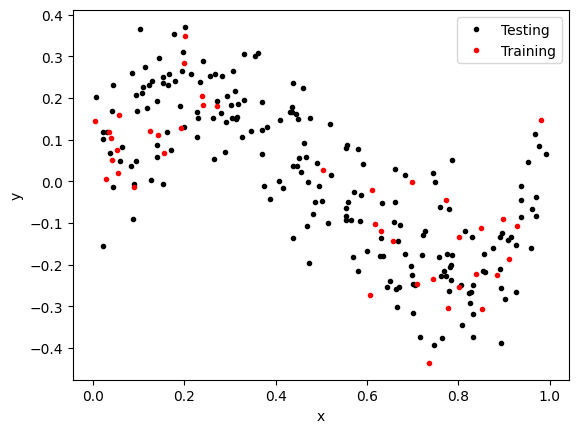

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Loading training and test data
x_train = np.loadtxt("data/x_train.csv", delimiter=",")
y_train = np.loadtxt("data/y_train.csv", delimiter=",")
x_test = np.loadtxt("data/x_test.csv", delimiter=",")
y_test = np.loadtxt("data/y_test.csv", delimiter=",")

# Plotting data purely for verification
plt.plot(x_train, y_train, "k.", x_test, y_test, "r.")
plt.xlabel("x")
plt.ylabel("y")
plt.legend({"Training", "Testing"})
plt.show()

# Fitting a Polynomial to the Data

The functions below provide an implementation of a linear fitting of polynomials to the data.

In [28]:
# Function that creates the X matrix as defined for fitting our model
def create_X(x, deg):
    X = np.ones((len(x), deg + 1))
    for i in range(1, deg + 1):
        X[:, i] = x**i
    return X


# Function for predicting the response
def predict(x, theta):
    return np.dot(create_X(x, len(theta) - 1), theta)


# Function for fitting the model
def fit(x, y, deg):
    return np.linalg.lstsq(create_X(x, deg), y, rcond=None)[0]


# Function for computing the MSE
def mse(y, yPred):
    se = (y - yPred) ** 2
    return np.sqrt(np.mean(se))

Now we fit the model to the data. Note that we are using the entire training set since we are not performing any model selection yet.

Training Error = 0.127
Test Error = 0.137


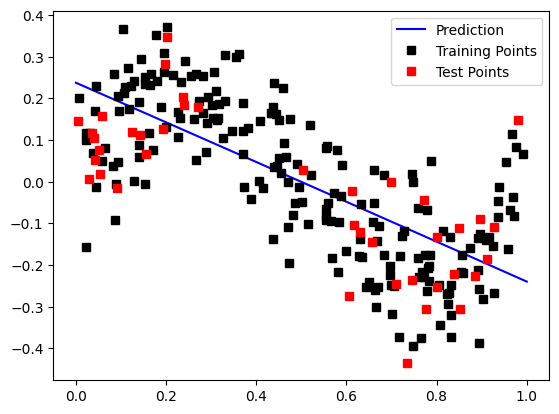

In [29]:
# Fitting model
deg = 2
theta = fit(x_train, y_train, deg)

# Computing training error
y_train_pred = predict(x_train, theta)
err = mse(y_train, y_train_pred)
print("Training Error = {:2.3}".format(err))

# Computing test error
y_test_pred = predict(x_test, theta)
err = mse(y_test, y_test_pred)
print("Test Error = {:2.3}".format(err))

# Plotting fitted model
x = np.linspace(0, 1, 100)
y = predict(x, theta)
plt.plot(x, y, "b-", x_train, y_train, "ks", x_test, y_test, "rs")
plt.legend(["Prediction", "Training Points", "Test Points"])
plt.show()

# Hyper-Parameter Selection using Polynomial Fitting

This section illustrates how to perform hyper-parameter selection where the capacity of the model is captured by the degree of the polynomial used for fitting.

## Question 1 [4 pts]

Your first tasks is to split the data into pre-val training and validation. We will keep all measurements in the same order as the original training set. This is to make the grading easier and consistent as I check for correctness. Complete the functions within the specified blocks.

In [30]:
# This function computes a 'kcurr' split out of a K-fold cross-
# validation. For example, to obtain the 1st fold of a 10 fold cross-
# validation, you would select 'K=10' and 'kcurr=1'.
def kfold_split(x, y, K, kcurr):
    # Extracting number of samples in the data
    N = len(x)

    # Specifying the number of samples in a fold
    Nfold = int(np.floor(N / K))

    # Initializing indices
    idxVal = []
    idxPreVal = []

    # Specify idxVal and idxPreVal in here so the date gets properly
    # split using the following commands.
    ###
    ### YOUR CODE HERE
    ###
    idxVal = np.arange(kcurr * Nfold, (kcurr + 1) * Nfold)
    idxPreVal = np.setdiff1d(np.arange(0, N), idxVal)

    x_preval = x[idxPreVal]
    y_preval = y[idxPreVal]

    x_val = x[idxVal]
    y_val = y[idxVal]

    return x_preval, y_preval, x_val, y_val


# This function computes the errors in the prevalidation trainging and
# validation datasets for each fold in the K-folds specified, and for
# each degree specified in 'degList'.
def kfold_crossval(x_train, y_train, degList, K):
    # Initializing range of degree values to be tested and errors.
    # Make sure your output has these dimensions.
    errPreVal = np.zeros((len(degList), K))
    errVal = np.zeros((len(degList), K))

    for i in range(0, K):
        x_preval, y_preval, x_val, y_val = kfold_split(x_train, y_train, K, i)

        # Computing pre-validation training and validation MSE for
        # each degree value. These lines of code should fill in the
        # values in the 'errPreVal' and 'errVal' arrays.
        ###
        ### YOUR CODE HERE
        ###
        for j in range(0, len(degList)):
            theta = fit(x_preval, y_preval, degList[j])
            y_preval_pred = predict(x_preval, theta)
            y_val_pred = predict(x_val, theta)
            errPreVal[j, i] = mse(y_preval, y_preval_pred)
            errVal[j, i] = mse(y_val, y_val_pred)

    return errPreVal, errVal

The following cell just shows how this the `kfold_split` would be executed in our dataset.

In [31]:
# This is the total number of folds
K = 10

# This is the function that needs to be modified within the specified block in the script.
# Note that the last entry is the current k-fold splid to be returned. That is, passing a
# value of 0 will return the first fold split with the first fold as the validation set.
x_preval, y_preval, x_val, y_val = kfold_split(x_train, y_train, K, 0)

print("Dimensions of Validation Set: {}".format(x_val.shape))
print("Dimensions of Pre-Validation Set: {}".format(x_preval.shape))

Dimensions of Validation Set: (20,)
Dimensions of Pre-Validation Set: (180,)


Checking for correctenss of the `kfold_split` function. [2 pts]

In [32]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([1, 2, 3, 4, 5, 6])

K = 6

# CHECKING FIRST TEST FIRST FOLD
x_preval, y_preval, x_val, y_val = kfold_split(x, y, K, 0)
tmp = np.array([2, 3, 4, 5, 6])
assert x_val == 1 and y_val == 1 or (x_preval == tmp).all() and (y_preval == tmp).all()

# CHECKING FIRST TEST FIFTH FOLD
x_preval, y_preval, x_val, y_val = kfold_split(x, y, K, 4)
tmp = np.array([1, 2, 3, 4, 6])
assert x_val == 5 and y_val == 5 or (x_preval == tmp).all() or (y_preval == tmp).all()

###
### AUTOGRADER TEST - DO NOT REMOVE
###

Checking for correctness of the `kfold_crossval` function. [2 pts]

In [33]:
def AlmostEqual(P, Q, digits):
    epsilon = 10**-digits
    return np.linalg.norm(P - Q) < epsilon


# List of degrees considered for the analysis
degList = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# This is the total number of folds
K = 10

# Getting arrays with the errors for all folds. We keep track of all errors so
# the mean and standard deviation can be computed below.
errPreVal, errVal = kfold_crossval(x_train, y_train, degList, K)

# Checking dimensions
assert (errPreVal.shape == (len(degList), K)) and (errVal.shape == (len(degList), K))

###
### AUTOGRADER TEST - DO NOT REMOVE
###

## Question 2 [2 pts]

Compute pre-validation training and validation errors for each of the listed degrees. The training error should show a decreasing pattern. The validation error should decrease and then increase.

In [34]:
# List of degrees considered for the analysis
degList = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# This is the total number of folds
K = 10

# Getting arrays with the errors for all folds. We keep track of all errors so
# the mean and standard deviation can be computed below.
errPreVal, errVal = kfold_crossval(x_train, y_train, degList, K)

# Computing mean of the prevalidation training error
errPreVal_mean = np.mean(errPreVal, axis=1)

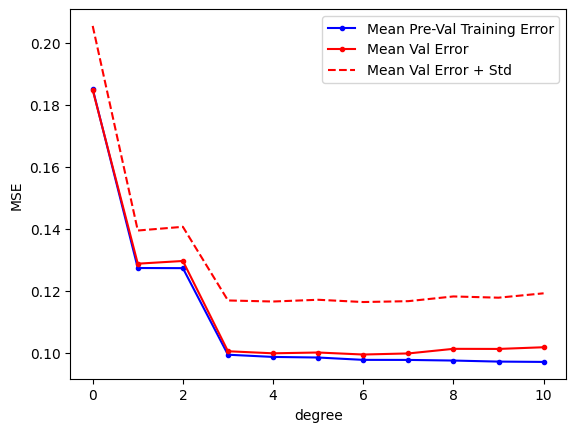

In [35]:
# Initializing the mean and std of errVal
errVal_mean = []
errVal_std = []

# Define the mean and std of errVal
###
### YOUR CODE HERE
###
errVal_mean = np.mean(errVal, axis=1)
errVal_std = np.std(errVal, axis=1)

# Plotting results
plt.plot(
    degList,
    errPreVal_mean,
    "b.-",
    degList,
    errVal_mean,
    "r.-",
    degList,
    errVal_mean + errVal_std,
    "r--",
)
plt.xlabel("degree")
plt.ylabel("MSE")
plt.legend(["Mean Pre-Val Training Error", "Mean Val Error", "Mean Val Error + Std"])
plt.show()

Checking for correcteness of arrays. [2 Pts]

In [36]:
### BEGIN
# Checking individual values
assert AlmostEqual(errVal_mean[0], 0.1847, 3) and AlmostEqual(errVal_mean[2], 0.1295, 3)
assert AlmostEqual(errVal_std[0], 0.0206, 3) and AlmostEqual(errVal_std[2], 0.0110, 3)

# Performance of Optimal Model

We begin by selecting the optimal degree using this rule: Select the most parsimonious model that has a cross-validation value within a standard deviation from the best model $d^*$.

In [37]:
# Getting the index of the degree with minimum mean validation error
idx = np.argmin(errVal_mean)

# Getting list of degrees that are below the mininum error plus the std
tmp = degList[errVal_mean < errVal_mean[idx] + errVal_std[idx]]

# The optimal degree is the minimum of the previous list
degOpt = min(tmp)

print("Optimal Degree = {}".format(degOpt))
print(
    "Mean Validation Error = {:.3f} +/- {:.3f}".format(
        errVal_mean[idx], errVal_std[idx]
    )
)

Optimal Degree = 3
Mean Validation Error = 0.099 +/- 0.017


Next, we fit a model with all the training data and show its performance.

Test Error = 0.095


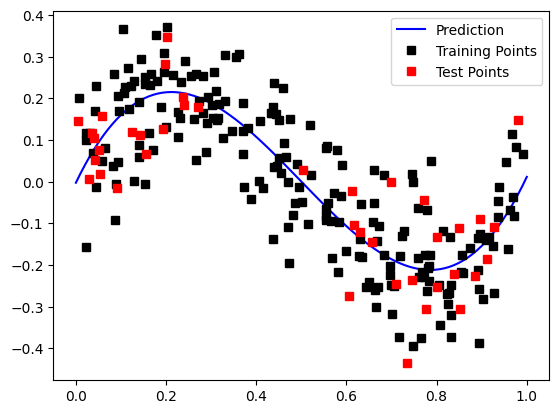

In [38]:
# Fitting the model
theta = fit(x_train, y_train, degOpt)
y_test_pred = predict(x_test, theta)
errTest = mse(y_test, y_test_pred)

# Displaying the test error
print("Test Error = {:.3f}".format(errTest))

# Plotting fitted model
x = np.linspace(0, 1, 100)
y = predict(
    x, theta
)  # Use the theta from the full training set for better visualization
plt.plot(x, y, "b-", x_train, y_train, "ks", x_test, y_test, "rs")
plt.legend(["Prediction", "Training Points", "Test Points"])
plt.show()